# Looking for the inversion in the GFS model

*Use the metpy conda environment, instead of the usual flc conda environment*

**Libraries used:**

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from metpy.plots import SkewT
from metpy.units import units

**Retrieve GFS and SST data:**

In [2]:
date_str = "20240620"

In [3]:
gfs_file = 'model_data/gfs_'+date_str
gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/metpy/lib/python3.12/site-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Applications/anaconda3/envs/metpy/lib/python3.12/site-packages/cfgrib/dataset.py", line 639, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,


In [4]:
sst_file = "sst_data/sst_"+date_str

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()

#--- Convert from C to K
sst_ds.sst.values = sst_ds.sst.values+273.15

**Create the datetime variable:**

In [5]:
datetime_str = np.datetime_as_string(gfs_ds.time.values, unit='h')
datetime_str = datetime_str.replace('T', ' ')+"Z"
print(datetime_str)

2024-06-20 00Z


**Select point for sounding:**

In [6]:
latitude = 43.8
longitude = -66.1

point = gfs_ds.sel(latitude=latitude, longitude=longitude, method='nearest')

In [7]:
surface = sst_ds.sel(lat=latitude, lon=longitude+360, method='nearest')

In [8]:
#---GFS 2m height (opened separately)

gfs_2m = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':2}})
point_2m = gfs_2m.sel(latitude=latitude, longitude=longitude, method='nearest')

**Plot the temperature sounding:**

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_75172/2629850056.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(minor='off',labels=yticklabels)


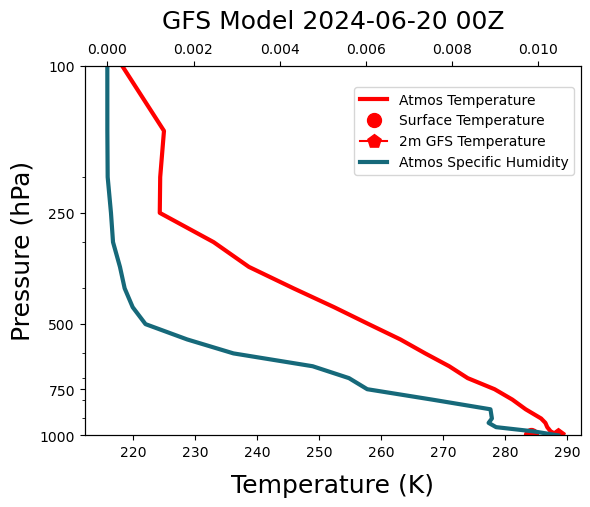

In [9]:
fig, ax = plt.subplots()

ax.plot(point.t, point.isobaricInhPa, c='r', linewidth=3, label='Atmos Temperature')
ax.plot(float(surface.sst.values), 1000, 'ro', markersize=10, label='Surface Temperature')
ax.plot(float(point_2m.t2m.values), 1000, c='r', marker=(5, 0), markersize=10, label='2m GFS Temperature')

ax.set_title('GFS Model '+ datetime_str, size=18, pad=10)
ax.set_xlabel('Temperature (K)', size=18, labelpad=10)
ax.set_ylabel('Pressure (hPa)', size=18)

ax2 = ax.twiny()
ax2.plot(point.q, point.isobaricInhPa, c='#16697A', linewidth=3, label='Atmos Specific Humidity')
fig.legend(bbox_to_anchor=(0.4, 0.35, 0.5, 0.5))

#---Y-labels took some wrangling
plt.yscale('log')
ax.set_ylim([1000,100])
ax.set_yticks([1000,750,500,250,100])
yticklabels = ['1000','750','500','250','100']
ax.set_yticklabels(yticklabels)
plt.gca().set_yticklabels(minor='off',labels=yticklabels)

#fig.savefig("/Users/jesseturner/Downloads/model_sounding_"+datetime_str, dpi=200, bbox_inches='tight')
plt.show()

**Creating the skew-t plot:**

In [10]:
pressure = point.isobaricInhPa.values * units.hPa
surface_temperature = float(surface.sst.values)
temperature_2m = float(point_2m.t2m.values)
temperature = np.append(temperature_2m, point.t.values)
temperature = np.append(surface_temperature, temperature)  * units.degK
pressure_temperature = np.append(1010.0 * units.hPa, pressure)
pressure_temperature = np.append(1025.0 * units.hPa, pressure_temperature)

In [11]:
#--- Converting from specific humidity to dewpoint

from metpy.calc import dewpoint

specific_humidity = point.q.values
mixing_ratio = specific_humidity / (1 - specific_humidity)
vapor_pressure = (mixing_ratio * pressure) / (0.622 + mixing_ratio)
dewpoints = dewpoint(vapor_pressure)

#--- Repeat for 2m height
#------ Using the same 1010 hPa as above
specific_humidity_2m = float(point_2m.sh2.values)
mixing_ratio_2m = specific_humidity_2m / (1 - specific_humidity_2m)
vapor_pressure_2m = (mixing_ratio_2m * 1010.0) / (0.622 + mixing_ratio_2m)
dewpoint_2m = dewpoint(vapor_pressure_2m * units.hPa)

#--- Append pressure level and 2m dewpoint
dewpoints = np.append(dewpoint_2m, dewpoints)
pressure_dewpoint = np.append(1010.0 * units.hPa, pressure)

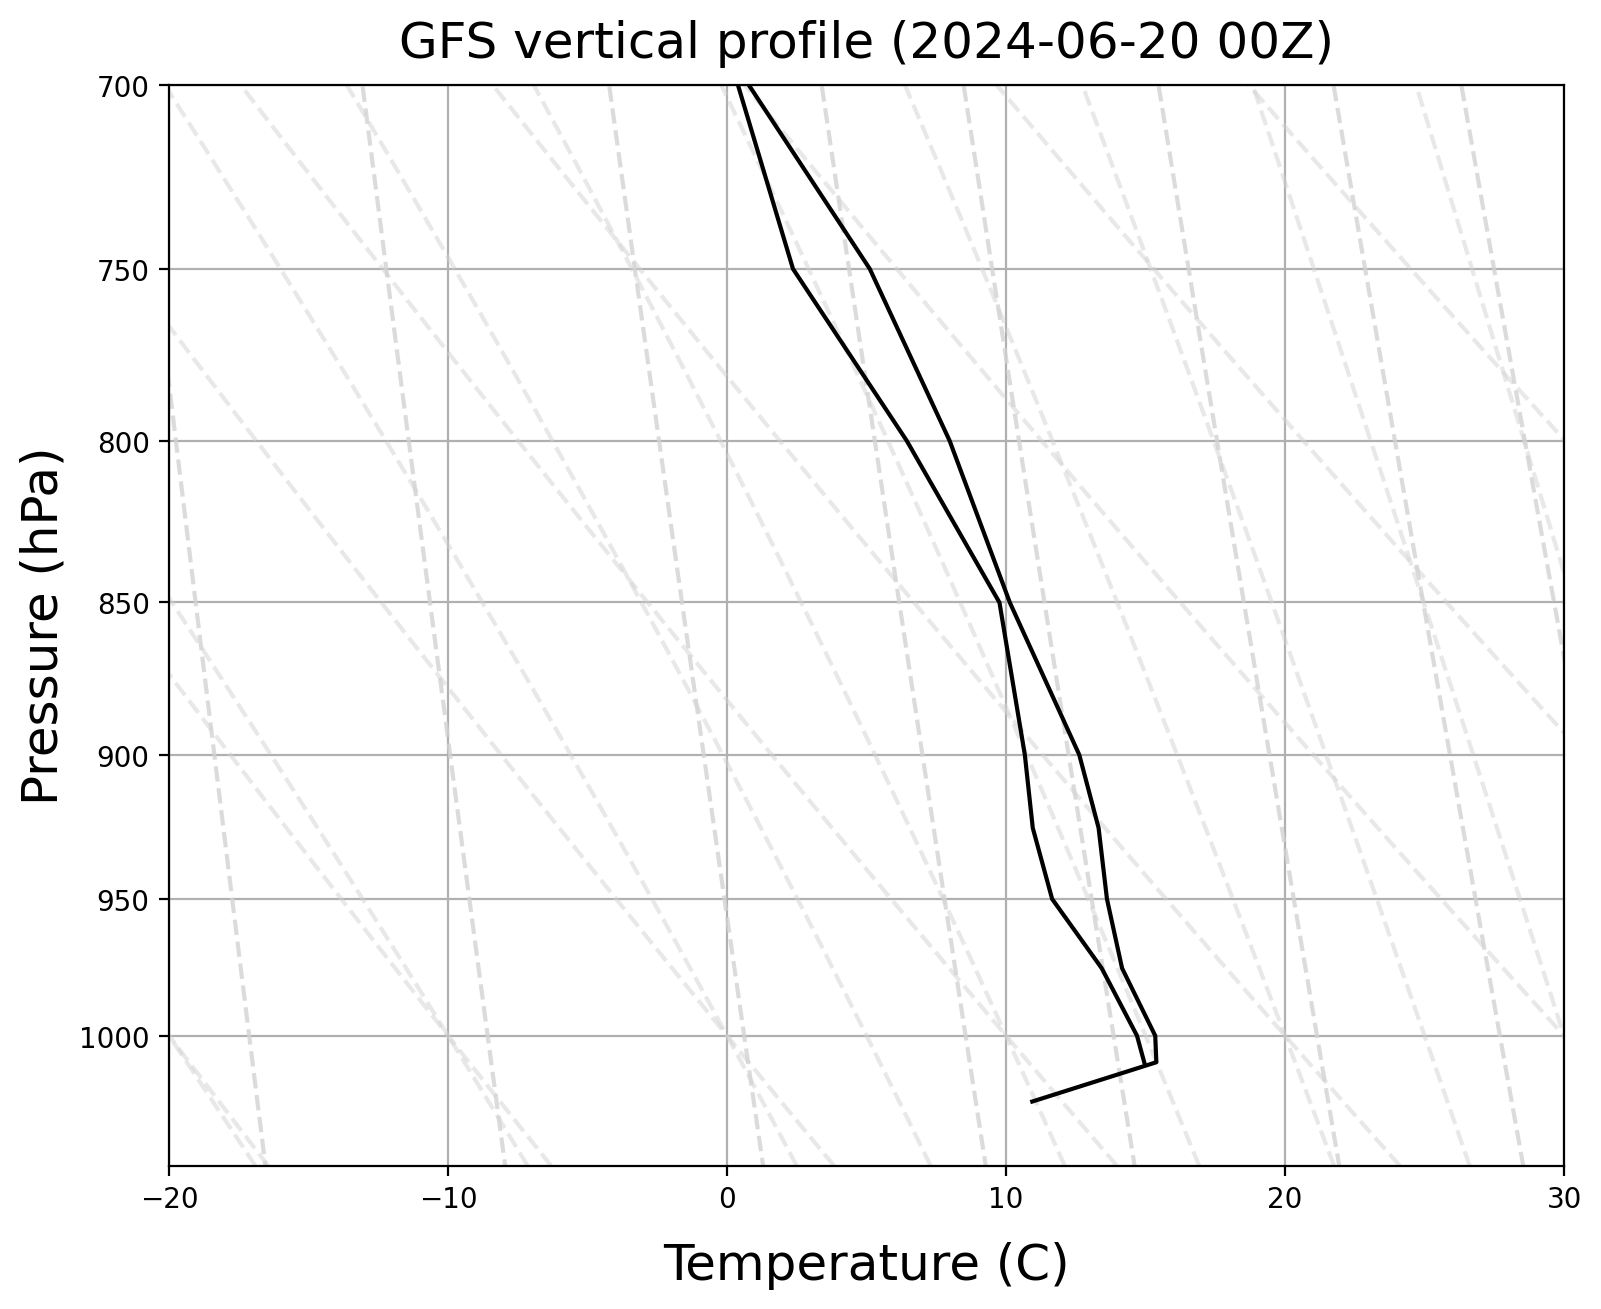

In [12]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, aspect=220, rotation=0)

# Plot the data
skew.plot(pressure_temperature, temperature, 'k', label='Temperature')
skew.plot(pressure_dewpoint, dewpoints, 'k', label='Dewpoint')

# Add a legend
#plt.legend()

# Add additional lines (like dry adiabats, moist adiabats, and mixing ratio lines)
skew.plot_dry_adiabats(colors='lightgray')
skew.plot_moist_adiabats(colors='lightgray')
skew.plot_mixing_lines(colors='lightgray')

# Set plot limits and labels
skew.ax.set_ylim(1050, 700)
skew.ax.set_yticks(np.arange(1000, 700 - 1, -50))
skew.ax.set_xlim(-20, 30)
skew.ax.set_xlabel('Temperature (C)', size=18, labelpad=10)
skew.ax.set_ylabel('Pressure (hPa)', size=18)

skew.ax.set_title('GFS vertical profile ('+ datetime_str+')', size=18, pad=10)
# Show the plot
fig.set_dpi(200)
plt.show()